# Importing Necessary libraries

In [2]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import cv2 
import glob
import random
from os import listdir
from sklearn.metrics import classification_report
import tensorflow as tf
import keras.utils as image


# Loading Dataset

In [3]:
breast_img = glob.glob('/kaggle/input/breast-histopathology-images/IDC_regular_ps50_idx5/**/*.png', recursive = True)

for imgname in breast_img[:3]:
    print(imgname)

/kaggle/input/breast-histopathology-images/IDC_regular_ps50_idx5/10295/0/10295_idx5_x1351_y1101_class0.png
/kaggle/input/breast-histopathology-images/IDC_regular_ps50_idx5/10295/0/10295_idx5_x1501_y501_class0.png
/kaggle/input/breast-histopathology-images/IDC_regular_ps50_idx5/10295/0/10295_idx5_x1501_y1101_class0.png


# Visualizing Dataset

In [ ]:
N_IDC = []
P_IDC = []

for img in breast_img:
    if img[-5] == '0' :
        N_IDC.append(img)
    
    elif img[-5] == '1' :
        P_IDC.append(img)
plt.figure(figsize = (15, 15))

some_non = np.random.randint(0, len(N_IDC), 18)
some_can = np.random.randint(0, len(P_IDC), 18)

s = 0
for num in some_non:
    
        img = image.load_img((N_IDC[num]), target_size=(100, 100))
        img = image.img_to_array(img)
        
        plt.subplot(6, 6, 2*s+1)
        plt.axis('off')
        plt.title('no cancer')
        plt.imshow(img.astype('uint8'))
        s += 1
s = 1
for num in some_can:
    
        img = image.load_img((P_IDC[num]), target_size=(100, 100))
        img = image.img_to_array(img)
        
        plt.subplot(6, 6, 2*s)
        plt.axis('off')        
        plt.title('IDC (+)')
        plt.imshow(img.astype('uint8'))
        s += 1


In [93]:

print(f"Total IDC(-) images: {len(N_IDC)}")
print(f"Total IDC(+) images: {len(P_IDC)}")

Total IDC(-) images: 198738
Total IDC(+) images: 78786


In [102]:
N_IDC = []
P_IDC = []

for img in breast_img:
    if img[-5] == '0':
        N_IDC.append(img)
    elif img[-5] == '1':
        P_IDC.append(img)



# Limit to 10,000 images each
N_IDC = N_IDC[:10000]
P_IDC = P_IDC[:10000]

# Data Preprocessing

In [95]:
non_img_arr = []
can_img_arr = []

for img in N_IDC:
    n_img = cv2.imread(img, cv2.IMREAD_COLOR)
    n_img_size = cv2.resize(n_img, (50, 50), interpolation=cv2.INTER_LINEAR)
    non_img_arr.append([n_img_size, 0])

for img in P_IDC:
    c_img = cv2.imread(img, cv2.IMREAD_COLOR)
    c_img_size = cv2.resize(c_img, (50, 50), interpolation=cv2.INTER_LINEAR)
    can_img_arr.append([c_img_size, 1])

print(f"Processed IDC(-) images: {len(non_img_arr)}")
print(f"Processed IDC(+) images: {len(can_img_arr)}")

Processed IDC(-) images: 10000
Processed IDC(+) images: 10000


In [96]:
# Combine and shuffle the arrays
breast_img_arr = non_img_arr + can_img_arr
random.shuffle(breast_img_arr)

X = []
y = []

for feature, label in breast_img_arr:
    X.append(feature)
    y.append(label)

X = np.array(X)
y = np.array(y)

In [97]:
def describeData(a, b):
    print('Total number of images: {}'.format(len(a)))
    print('Number of IDC(-) Images: {}'.format(np.sum(b == 0)))
    print('Number of IDC(+) Images: {}'.format(np.sum(b == 1)))
    print('Image shape (Width, Height, Channels): {}'.format(a[0].shape))

describeData(X, y)


Total number of images: 20000
Number of IDC(-) Images: 10000
Number of IDC(+) Images: 10000
Image shape (Width, Height, Channels): (50, 50, 3)


In [98]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

Y = to_categorical(y, num_classes=2)

# Split data into training, testing, and validation sets (80% train, 10% validation, 10% test)
X_train, X_temp, Y_train, Y_temp = train_test_split(X, Y, test_size=0.2, random_state=42)
X_val, X_test, Y_val, Y_test = train_test_split(X_temp, Y_temp, test_size=0.5, random_state=42)

print("Training Data Shape:", X_train.shape)
print("Validation Data Shape:", X_val.shape)
print("Testing Data Shape:", X_test.shape)


Training Data Shape: (16000, 50, 50, 3)
Validation Data Shape: (2000, 50, 50, 3)
Testing Data Shape: (2000, 50, 50, 3)


# Modeling

In [13]:
from sklearn.metrics import classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import VGG16
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix
import itertools

In [99]:
early_stop = EarlyStopping(monitor='val_loss', patience=5)

# Load pre-trained VGG16 model without top layers
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(50, 50, 3))

for layer in base_model.layers:
    layer.trainable = False


# Add custom top layers
x = Flatten()(base_model.output)
x = Dense(128, activation='relu', kernel_initializer='he_uniform')(x)  
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(64, activation='relu', kernel_initializer='he_uniform')(x)  
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
output = Dense(2, activation='softmax')(x) 

VGG16_model = Model(inputs=base_model.input, outputs=output, name="VGG16")

VGG16_model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'], run_eagerly=True)

VGG16_model.summary()

Model: "VGG16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 50, 50, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 50, 50, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 50, 50, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 25, 25, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 25, 25, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 25, 25, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 12, 12, 128)       0     

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(VGG16_model, to_file='model_architecture.png', show_shapes=True, show_layer_names=True)

from IPython.display import Image
Image('model_architecture.png')

In [101]:
history = VGG16_model.fit(X_train, Y_train, epochs=20, batch_size=35, validation_data=(X_val, Y_val))

Epoch 1/20
458/458 [==============================] - 37s 77ms/step - loss: 0.8837 - accuracy: 0.5928 - val_loss: 0.5686 - val_accuracy: 0.7325
Epoch 2/20
458/458 [==============================] - 35s 77ms/step - loss: 0.6902 - accuracy: 0.7032 - val_loss: 0.5208 - val_accuracy: 0.7525
Epoch 3/20
458/458 [==============================] - 35s 77ms/step - loss: 0.6245 - accuracy: 0.7329 - val_loss: 0.4987 - val_accuracy: 0.7660
Epoch 4/20
458/458 [==============================] - 35s 77ms/step - loss: 0.5917 - accuracy: 0.7456 - val_loss: 0.4785 - val_accuracy: 0.7730
Epoch 5/20
458/458 [==============================] - 35s 77ms/step - loss: 0.5576 - accuracy: 0.7611 - val_loss: 0.4689 - val_accuracy: 0.7825
Epoch 6/20
458/458 [==============================] - 35s 77ms/step - loss: 0.5393 - accuracy: 0.7666 - val_loss: 0.4598 - val_accuracy: 0.7820
Epoch 7/20
458/458 [==============================] - 36s 78ms/step - loss: 0.5241 - accuracy: 0.7686 - val_loss: 0.4515 - val_accuracy:

# Model Evaluation

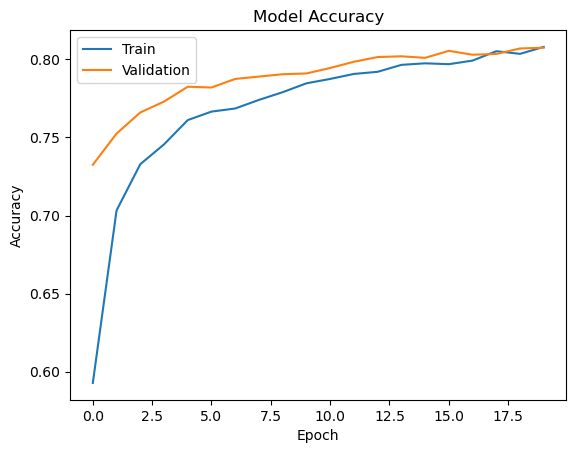

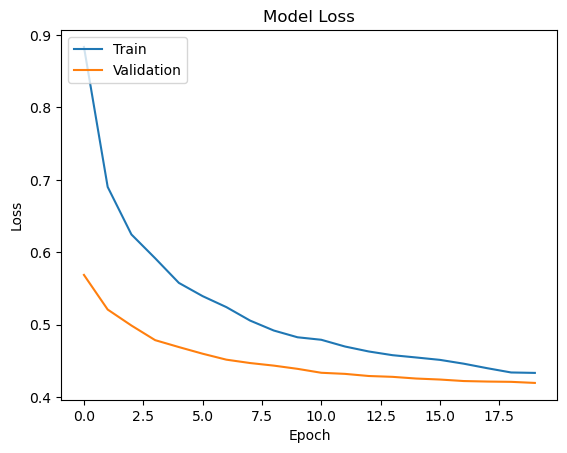

In [103]:

# Plot training and validation accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training and validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()



63/63 [==============================] - 1s 18ms/step
              precision    recall  f1-score   support

     Class 0    0.81871   0.84478   0.83154      1005
     Class 1    0.83801   0.81106   0.82431       995

    accuracy                        0.82800      2000
   macro avg    0.82836   0.82792   0.82792      2000
weighted avg    0.82831   0.82800   0.82794      2000



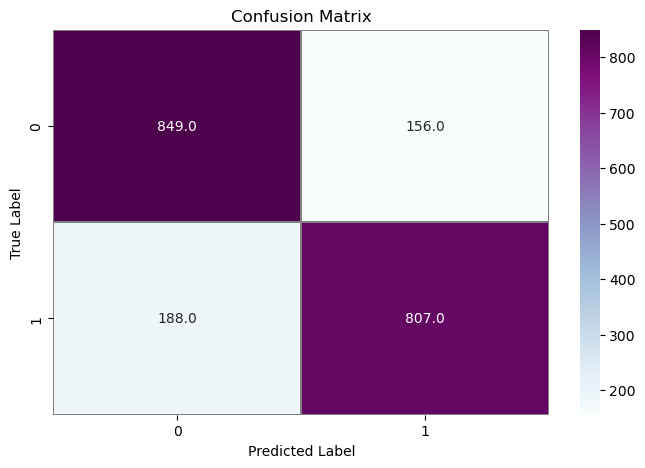

In [104]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

class_names = ['Class 0', 'Class 1']

# Predict classes for test set
Y_pred = VGG16_model.predict(X_test)
Y_pred_classes = np.argmax(Y_pred, axis=1)
Y_true = np.argmax(Y_test, axis=1)

print(classification_report(Y_true, Y_pred_classes, target_names=class_names, digits=5))

confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)
plt.figure(figsize=(8, 5))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01, cmap="BuPu", linecolor="gray", fmt='.1f')
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix

Y_pred_classes = np.argmax(Y_pred, axis=1)
Y_true = np.argmax(Y_test, axis=1)

confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)

confusion_mtx_percent = confusion_mtx.astype('float') / confusion_mtx.sum(axis=1)[:, np.newaxis] * 100

f, ax = plt.subplots(figsize=(8, 5))
sns.heatmap(confusion_mtx_percent, annot=True, linewidths=0.01, cmap="BuPu", linecolor="gray", fmt='.1f', ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (Percentage)")
plt.show()


In [106]:
VGG16_model.evaluate(X_test,Y_test)

63/63 [==============================] - 2s 26ms/step - loss: 0.3933 - accuracy: 0.8280


[0.39328938722610474, 0.828000009059906]

# Model Save

In [ ]:
model.save("/kaggle/working/Brest CNN 2.h5")
